### Deep Learning Miniproject - Audio

AVS 8th Semester - Group 841

In [55]:
import os
import torchaudio as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from numba import jit

import IPython.display as ipd

import librosa
import librosa.display

import torch
from torch import nn
import torch.optim 
#from transformers import ASTFeatureExtractor
from torch.utils.data import random_split, DataLoader, Dataset
import pytorch_lightning as pl


# Hyperparameters

In [62]:
#Hyperparaeters

AUDIO_DIR = "./data/Data/"
CSV_DIR = "./data/metadata_compiled.csv"
FILE_TYPE = ".wav"
BATCH_SIZE = 16

#### 1. Explore the dataset through code

a. How many samples does the dataset contain?

In [57]:
#Load the data!
df = pd.read_csv(CSV_DIR)

#Check no. samples
print(f'Number of samples : {df.shape[0]}')

Number of samples : 27550


b. How many classes? How many samples per class? Show a histogram of the number of intances per class

In [58]:
print(f'Number of classes: {len(df["status"].unique())}.\n\
    Classes: {df["status"].unique()}\n\
    {pd.value_counts(df["status"], dropna=False)}')

Number of classes: 4.
    Classes: [nan 'healthy' 'COVID-19' 'symptomatic']
    healthy        12479
NaN            11326
symptomatic     2590
COVID-19        1155
Name: status, dtype: int64


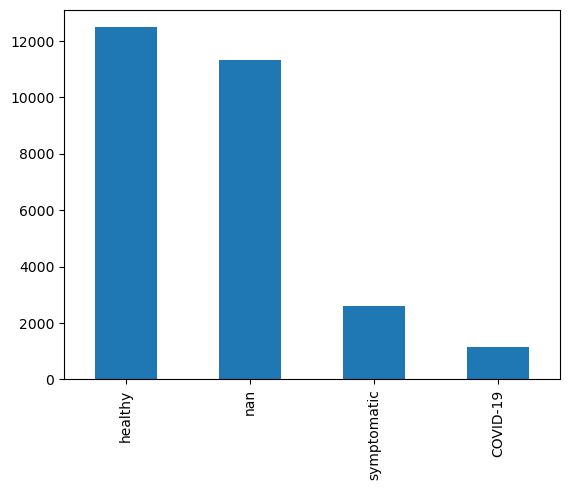

In [43]:
# some problem with this shit
pd.value_counts(df['status'], dropna=False).plot.bar()
plt.show()

c. Play a random sample from each class

In [48]:
# playing healthy
healthy = df[df['status'] == 'healthy'].sample()['uuid'].item()
path = AUDIO_DIR + healthy + FILE_TYPE
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

/tmp/ipykernel_343181/1290488024.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path)


FileNotFoundError: [Errno 2] No such file or directory: './data/Data/3fc6450d-d5a3-47a0-8f31-60139f6fe272.wav'

In [38]:
# playing COVID-19
covid = df[df['status'] == 'COVID-19'].sample()['uuid'].item()
path = AUDIO_DIR + covid + FILE_TYPE
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

/tmp/ipykernel_343181/34731780.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path)


FileNotFoundError: [Errno 2] No such file or directory: './data/Data/dbb52561-93ca-444e-9ff9-e61fd6c6996f.wav'

In [ ]:
# playing symptomatic
symptomatic = df[df['status'] == 'symptomatic'].sample()['uuid'].item()
path =  AUDIO_DIR + symptomatic + FILE_TYPE
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

d. Describe if/how you think the data distribution will affect training of a classifier

e. Decide what part of the dataset to use; all, some classes, some samples. Motivate your choice

#### 2. Use a neural network of your own chose to classify the dataset. Explain your choice and at least one alternative. Document your experiences:.

#### Audio Spectogram Transformer Implementation

##### A Dataset class is created to load the dataset

In [59]:
class AudioDatatset(Dataset):
    def __init__(self, audio_dir, class_csv):
        self.audio_dir = audio_dir
        self.df = pd.read_csv(class_csv)

        self.audio_dir_list = os.listdir(self.audio_dir)

    def __len__(self):
        return len(self.audio_dir_list)
    
    def __getitem__(self, idx):
        audio_file_path = os.path.join(self.audio_dir, self.audio_dir_list[idx])
 
        waveform, sample_rate = ta.load(audio_file_path, normalize=True)
        
        #print(type(waveform))
        #print(sample_rate)
        transform = ta.transforms.MelSpectrogram(sample_rate, n_mels=32)
        mel_specgram = transform(waveform) 

        audio_file_name = self.audio_dir_list[idx].replace(FILE_TYPE, '')

        #Transform 
        #Spectogram

        i =  self.df[ self.df['uuid']==audio_file_name].index.values
        label =  self.df["status"].loc[ self.df.index[i].values[0]]

        return mel_specgram, label 


##### Testing the Dataset class

In [73]:
test = AudioDatatset(AUDIO_DIR, CSV_DIR)
print(test.__getitem__(0))
print(test.__len__())

(tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.6694e-06,
          5.7855e-06, 3.0521e-06],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.2238e-06,
          4.7898e-06, 2.5738e-06],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0420e-06,
          6.5483e-08, 1.6850e-07],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.6220e-07,
          3.0945e-08, 7.8637e-08],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.1619e-07,
          2.4514e-08, 1.1150e-07],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.9584e-08,
          1.8637e-08, 1.2825e-07]]]), 'healthy')
2214


##### DataLoader class

In [93]:
class DataModuleClass(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        #self.transform = transforms.MelSpectrogram(sample_rate)
        self.batch_size = batch_size
        self.audio_files =  []

    def prepare_data(self):
        
        pass
        #Define steps that should be done
        #only on one GPU, like getting data

    def setup(self, stage=None):
        #Apply melSpectogram transform
        self.audio_files = AudioDatatset(AUDIO_DIR, CSV_DIR)

        #Splitting manually 
        audio_len = self.audio_files.__len__()
        train_size = round(audio_len * 0.7)
        val_size = round(audio_len * 0.2)
        test_size = audio_len - train_size - val_size
        
        self.train_data, self.val_data, self.test_data = random_split(self.audio_files, [train_size, val_size, test_size])

        #Define steps that should be done on every GPU,
        #like splitting data, applying transform etc.

    def train_dataloader(self):
        return DataLoader(self.train_data, self.batch_size)        

    def val_dataloader(self):
        return DataLoader(self.val_data, self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, self.batch_size)   


In [94]:
data_set = DataModuleClass(BATCH_SIZE)
data_set.setup()
data_train = data_set.train_dataloader()

##### Loading and pre-processing data

In [3]:
from datasets import load_dataset, DatasetDict

# must have metadata.csv with 'file_name' column to have also the features
# unsplitted dataset
dataset = load_dataset("audiofolder", data_dir="./data", split="train")

Resolving data files: 100%|██████████| 16226/16226 [00:00<00:00, 20650.88it/s] 
Found cached dataset audiofolder (C:/Users/Kata/.cache/huggingface/datasets/audiofolder/default-800512f330983e37/0.0.0/6cbdd16f8688354c63b4e2a36e1585d05de285023ee6443ffd71c4182055c0fc)


In [4]:
# splitting up the data : {training - 70%, validation - 20%, test - 10%}
# shuffle=True
train_testvalid = dataset.train_test_split(test_size=0.3)
test_valid = train_testvalid['test'].train_test_split(test_size=1/3)

In [5]:
dataset = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'valid' : test_valid['train']
})

In [6]:
# getting the labels for classification
labels = list(df["status"].unique()[1:])

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [7]:
max_duration = 1

samplin_rate = 16000
batch_size = 8
num_classes = len(labels)
learning_rate = 1e-4
hidden_dim = 768

max_seq_length = max_duration * samplin_rate
max_frames = 49
max_epochs = 2


is_cuda = False # torch.cuda.is_available()
checkpoint = 'MIT/ast-finetuned-audioset-10-10-0.4593'

##### Training Model

In [8]:
# https://huggingface.co/docs/transformers/main/en/model_doc/audio-spectrogram-transformer#transformers.ASTConfig
from transformers import ASTFeatureExtractor, ASTForAudioClassification
# ASTConfig, 

# must be the same -> model and tokenizer/feature extractor
# right now with default values

#config = ASTConfig()

# basically tokenizer
# input normalization: mean = 0, std = 0.5

#feature_extractor = ASTFeatureExtractor(config, sampling_rate=sr, num_mel_bins=32, mean=0, std=0.5)

#model = ASTForAudioClassification(config)

In [9]:
feature_extractor = ASTFeatureExtractor(
    checkpoint,
    return_attention_mask=True
)

In [10]:
# for feature extraction - using map()
def preprocess(examples):
    audio_arr = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arr,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=max_seq_length,
        truncation=True,
        padding=True
    )
    return inputs

In [11]:
dataset['train'] = dataset['train'].map(
    preprocess, remove_columns=["audio"], batched=True, batch_size=batch_size
    )

dataset['valid'] = dataset['valid'].map(
    preprocess, remove_columns=["audio"], batched=True, batch_size=batch_size
    )

dataset['test'] = dataset['test'].map(
    preprocess, remove_columns=["audio"], batched=True, batch_size=batch_size
    )

OSError: [Errno 28] No space left on device

In [18]:
model = ASTForAudioClassification.from_pretrained(
    checkpoint, 
    num_labels=len(labels),
    ignore_mismatched_sizes=True
    )

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model.parameters()

<generator object Module.parameters at 0x000001A61E82C040>

In [20]:
optimizer = "adamw_torch"
#torch.optim.AdamW(model.parameters())

In [ ]:
scheduler = 

In [21]:
from transformers import TrainingArguments, Trainer

# the hyperparams for Trainer
training_arg = TrainingArguments(
    output_dir="output",
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=1,
    learning_rate=learning_rate,
    lr_scheduler_type="linear",
    optim=optimizer,
    num_train_epochs= max_epochs,
    save_strategy="epoch",
    no_cuda=is_cuda
    )

In [ ]:
trainer = Trainer(
    model,
    training_arg,
    train_dataset=dataset['train'],
    eval_dataset=dataset['valid'],
    optimizers=(optimizer, scheduler)
)

In [ ]:
trainer.train()

In [ ]:
# evaluation
predictions = trainer.predict()


In [ ]:
# saving model weigths into files
model.save_pretrained('./saved_model/')

In [ ]:
# https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/trainer#transformers.TrainingArguments

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=epochs,
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    save_total_limit=1, # limit the total amount of checkpoints, deletes older chps in output_dir
    per_device_train_batch_size = batchsize,
    per_device_eval_batch_size = batchsize,
    logging_steps=500,
)
#report_to="tensorboard",

#optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_cosine(100,max_lr=lr,total_steps=total_steps, optimizer_lr=lr,min_lr=1e-6))

In [ ]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset= None, # TODO
    eval_dataset=None, # TODO
    #tokenizer=feature_extractor, TODO
    compute_metrics=compute_metrics,
    #optimizers=(optimizer, scheduler)
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

a. Discuss at least four relevant hyper-parameters

Learning rate : \
Epoch Numer : \
Batch Size : \
Optimizer: \
Layer Number : [??]

In [ ]:
# learning rate
# epoch number
# mini-batch size

# I don't know what is the 4th one

b. Experiment with the effect of different batch sizes

c. Experiment with the effect of different learning rates

d. Experiment with different number of network layers

e. Implement at least two data agumentation techniques

f. Discuss what influences the memory use of a solution such as yours. What can be done to reduce this?